<a href="https://colab.research.google.com/github/briag1/ProjetLong/blob/main/Projet_Long_3_dt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
# @title device
def get_device():
  if torch.cuda.is_available():
      device = torch.device("cuda")
      print("CUDA is available. Using GPU.")
  else:
      device = torch.device("cpu")
      print("CUDA is not available. Using CPU.")
  return device
device=get_device()

CUDA is not available. Using CPU.


# Preprocessing

In [1]:
# @title code
from os import makedirs
import torch
import math
import os
import string
import shutil
import subprocess
import pandas as pd
import numpy as np
import pandas as pd

def get_x(value):

    if isinstance(value, str):
        return float(value.split("/")[0])
    elif isinstance(value, float):
        return value

def get_y(value):

    if isinstance(value, str):
        return float(value.split("/")[1])
    elif isinstance(value, float):
        return value

def read_dataframe(name):
  if not os.path.exists(name+".pkl"):
    print("reading dataframe: "+name+".xlsx")
    df=pd.read_excel(name+".xlsx")
    df.to_pickle(name+".pkl")
  else:
    print("using already read daframe")

def get_vocab(poses,vocab):
  for pos in poses:
    if pos not in vocab and not any(isinstance(n, float) and math.isnan(n) for n in pos):
        vocab[pos]=len(vocab)+1
  return vocab

def get_fix_time_encoding(df):

  df['month_sin'] = np.sin(2 * np.pi * df["start time"].dt.month / 12)
  df['month_cos'] = np.cos(2 * np.pi * df["start time"].dt.month / 12)

  df['day_sin'] = np.sin(2 * np.pi * df["start time"].dt.day / 31)
  df['day_cos'] = np.cos(2 * np.pi * df["start time"].dt.day / 31)

  df['hour_sin'] = np.sin(2 * np.pi * df["start time"].dt.hour / 24)
  df['hour_cos'] = np.cos(2 * np.pi * df["start time"].dt.hour / 24)

  df['minute_sin'] = np.sin(2 * np.pi * df["start time"].dt.minute / 60)
  df['minute_cos'] = np.cos(2 * np.pi * df["start time"].dt.minute / 60)

  df['second_sin'] = np.sin(2 * np.pi * df["start time"].dt.second / 60)
  df['second_cos'] = np.cos(2 * np.pi * df["start time"].dt.second / 60)
def get_time_data(df):
  df['month'] =  df["start time"].dt.month
  df['day'] =  df["start time"].dt.day
  df['hour'] =  df["start time"].dt.hour
  df['minute'] = df["start time"].dt.minute
  df['second'] = df["start time"].dt.second
  return df


def tokenize_pos(pos,vocab):

  if math.isnan(pos[0]) and math.isnan(pos[1]):
    return len(vocab)
  else:
    return vocab[pos]

def get_coordinates(df,input_position,full_dataset):

  if full_dataset:
    df['x'] = df['latitude']
    df['y'] = df['longitude']
  else:
    df['x'] = df['location(latitude/lontitude)'].apply(get_x)
    df['y'] = df['location(latitude/lontitude)'].apply(get_y)


  if input_position:
    df['x_normalised']=(df['x']-df['x'].mean())/(df['x'].std())
    df['y_normalised']=(df['y']-df['y'].mean())/df['y'].std()

  return df

def get_joined_coordinates(df):

  df['pos']= list(zip(df['x'],df['y']))
  poses=df['pos'].unique()

  return poses

def get_col_to_keep_and_drop(fixed_time_encoding,input_position,full_dataset):
  col_to_drop_in_df=['date', 'end time','pos']
  col_to_drop_in_dict=['x','y', 'time_to_end', 'time_to_next','start time', 'user id']
  col_to_add_to_dict=[]
  col_in_input=[]
  if not full_dataset:
    col_to_drop_in_df+=['location(latitude/lontitude)']
  else:
    col_to_drop_in_df+=['latitude','longitude']
  if fixed_time_encoding:
    col_to_drop_in_df+=[]
    col_to_drop_in_dict+=['month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos']
    col_in_input+=['month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos']
  else:
    col_to_add_to_dict+=['month','day','hour','minute','second']
  if input_position:
    col_to_drop_in_dict += ['x_normalised', 'y_normalised']
    col_in_input+=['x_normalised', 'y_normalised']
  return col_to_drop_in_df,col_to_drop_in_dict,col_in_input,col_to_add_to_dict

def process_user_data(df_user,vocab,col_in_input,col_to_drop_in_dict,col_to_add_to_dict,with_repeated_connections):
  #get the time to next connection
  df_user["time_to_next"] =  df_user["start time"].diff(-1).dt.total_seconds()
  dict_user=df_user.to_dict('list')
  #create input
  dict_user["pos_id"],dict_user["pos_id_target"]=torch.tensor(dict_user["pos_id"][:-1]),torch.tensor(dict_user["pos_id"][1:])

  if col_in_input:
    dict_user["input"]=torch.tensor([dict_user[col] for col in col_in_input]).T
    dict_user["input"]=dict_user["input"][:-1]

  if col_to_add_to_dict:
    for col in col_to_add_to_dict:
      dict_user[col]=torch.tensor(dict_user[col])
      dict_user[col]=dict_user[col][:-1]

  dict_user["time_target"]=torch.tensor([dict_user["time_to_end"],dict_user["time_to_next"]]).T
  dict_user["time_target"]=dict_user["time_target"][:-1]
  for e in col_to_drop_in_dict:
    dict_user.pop(e)

  if not with_repeated_connections:
    dict_user=combine_repeated_connections_in_sequence_user(dict_user)
  return dict_user




def combine_repeated_connections_in_sequence_user(dict_user):
  index=0
  for key in dict_user:
    if dict_user[key].shape[0]!=dict_user["pos_id"].shape[0]:
      print(key)
  #print(dict_user["pos_id"],dict_user["pos_id_target"])
  while index < len(dict_user["pos_id"])-1:
    #print(dict_user["pos_id"][index],dict_user["pos_id_target"][index])
    if dict_user["pos_id"][index]==dict_user["pos_id_target"][index]:
      #print("equal")
      dict_user["pos_id_target"][index]=dict_user["pos_id_target"][index+1]
      dict_user["time_target"][index]=dict_user["time_target"][index+1]
      for key in dict_user:

        dict_user[key]=torch.cat((dict_user[key][:index+1],dict_user[key][index+2:]))
      #print()
    else:
      #print("different")
      index+=1


  return dict_user


def normalize_output(list_users):
  #get means and stds
  time_targets=torch.cat([dict_user["time_target"] for dict_user in list_users],dim=0)
  time_targets_mean=time_targets.mean(dim=0)
  time_targets_std=time_targets.std(dim=0)
  #normalize
  for i in range(len(list_users)):
    list_users[i]["time_target"]=(list_users[i]["time_target"]-time_targets_mean)/time_targets_std
  return list_users



def process_dataframe(name,vocab,fixed_time_encoding,input_position,full_dataset,with_repeated_connections,format=".pkl"):
  df= pd.read_pickle(name+format)
  df=df.sort_values('start time')
  df=df.drop(['month'],axis=1)

  df=get_coordinates(df,input_position,full_dataset)

  poses=get_joined_coordinates(df)
  vocab=get_vocab(poses,vocab)
  df['pos_id'] = df['pos'].apply(lambda pos: tokenize_pos(pos,vocab))

  df['time_to_end']=df['end time']-df['start time']
  df['time_to_end']=df['time_to_end'].dt.total_seconds()
  if fixed_time_encoding:
    df=get_fix_time_encoding(df)
  else:
    df=get_time_data(df)

  col_to_drop_in_df,col_to_drop_in_dict,col_in_input,col_to_add_to_dict=get_col_to_keep_and_drop(fixed_time_encoding,input_position,full_dataset)
  df=df.drop(col_to_drop_in_df, axis=1)

  df_user_group = df.groupby('user id')
  list_users=[]
  for user, df_user in df_user_group:
    if len(df_user)>=2 and not df_user['x'].isnull().values.any():
        list_users.append(process_user_data(df_user,vocab,col_in_input,col_to_drop_in_dict,col_to_add_to_dict,with_repeated_connections))
  list_users=normalize_output(list_users)

  return list_users,vocab

def runcmd(cmd, verbose = False, *args, **kwargs):

    process = subprocess.Popen(
        cmd,
        stdout = subprocess.PIPE,
        stderr = subprocess.PIPE,
        text = True,
        shell = True
    )
    std_out, std_err = process.communicate()
    if verbose:
        print(std_out.strip(), std_err)
    pass

def get_raw_data(directory,src_directory,full_dataset):
  if  full_dataset:
    shutil.copytree(src_directory,directory)#telecomDataset6mont
  else:
    runcmd('wget http://sguangwang.com/dataset/telecom.zip', verbose = False)
    runcmd('unzip /content/telecom.zip')

def get_processed_dataset(load_dataset_path):
  saved_list_user_path = os.path.join(load_dataset_path,"list_users")
  saved_vocab_path = os.path.join(load_dataset_path,"vocab")
  print("loading already preprocessed data: ")
  print(saved_list_user_path)
  print(saved_vocab_path)
  list_users=torch.load(saved_list_user_path)
  vocab=torch.load(saved_vocab_path)
  return list_users,vocab

def process_raw_data(src_directory_raw_data,directory_raw_data,fixed_time_encoding,input_position,full_dataset,with_repeated_connections):
  list_users=[]
  vocab={}
  if not os.path.exists(directory_raw_data):
    print('getting raw data at: '+src_directory_raw_data)
    get_raw_data(directory_raw_data,src_directory_raw_data,full_dataset)
  if full_dataset:
    for name in os.listdir(directory_raw_data):
      if not name.endswith(".pkl"):
        complete_name=os.path.join(directory_raw_data,".".join(name.split(".")[:-1]))
        print("processing dataframe: "+complete_name)
        read_dataframe(complete_name)
        new_list_users,vocab= process_dataframe(complete_name,vocab,fixed_time_encoding=fixed_time_encoding,input_position=input_position,full_dataset=full_dataset,with_repeated_connections=with_repeated_connections)
        list_users+=new_list_users
  else:
    complete_name = "/content/dataset-telecom/data_6.1~6.30_"
    read_dataframe(complete_name)
    list_users,vocab= process_dataframe(complete_name,vocab,fixed_time_encoding=fixed_time_encoding,input_position=input_position,full_dataset=full_dataset,with_repeated_connections=with_repeated_connections)

  return list_users,vocab

def split_long_sequences(list_users,max_sequence_length):
  new_list_users=[]
  for i in range(len(list_users)):
    seq_length=list_users[i]["input"].shape[0]
    if seq_length>=max_sequence_length:
      nb_of_seq=seq_length//max_sequence_length
      rest=seq_length%max_sequence_length
      list_splitted_seq=nb_of_seq*[{}]
      rest_splitted={}
      for key in list_users[i]:
        for j in range(nb_of_seq):
          list_splitted_seq[j][key]=list_users[i][key][max_sequence_length*j:max_sequence_length*(j+1)]
        if rest>2:
          rest_splitted[key]= list_users[i][key][-rest:]
      new_list_users=new_list_users+list_splitted_seq
      if len(rest_splitted)>0:
        new_list_users+=[rest_splitted]
    else:
      new_list_users.append(list_users[i])

  return new_list_users



def save_processed_data(list_users,vocab,path_to_save_dataset):
    print("creating directory: "+path_to_save_dataset)
    os.makedirs(path_to_save_dataset,exist_ok=True)
    print("saving processed data at: ")
    save_list_user_path = os.path.join(path_to_save_dataset,"list_users")
    save_vocab_path = os.path.join(path_to_save_dataset,"vocab")
    print(save_list_user_path)
    print(save_vocab_path)
    torch.save(list_users,save_list_user_path)
    torch.save(vocab,save_vocab_path)

def get_processed_data(src_directory_raw_data,directory_raw_data,fixed_time_encoding,input_position,full_dataset,spliting_long_sequences,with_repeated_connections,max_sequence_length=100,min_sequence_length=3,save=False,path_to_save_dataset="/content/drive/MyDrive/telecomDataset6month",download=False,load_dataset_path="/content/drive/MyDrive/telecomDataset6month"):
  if not download:
    list_users,vocab = get_processed_dataset(load_dataset_path)
  else:
    list_users,vocab=process_raw_data(src_directory_raw_data,directory_raw_data,fixed_time_encoding,input_position,full_dataset,with_repeated_connections)
  if spliting_long_sequences:
    print("spliting sequences longuer than : "+str(max_sequence_length)+ " steps")
    list_users=split_long_sequences(list_users,max_sequence_length)
  if save:
    save_processed_data(list_users,vocab,path_to_save_dataset)
  return list_users,vocab

In [3]:
# list_users,vocab=get_processed_data(src_directory_raw_data="drive/MyDrive/Shanghai-Telcome-Six-Months-DataSet",
#                                     directory_raw_data='/content/dataset-telecom-6month',
#                                     fixed_time_encoding=False,
#                                     input_position=True,
#                                     full_dataset=False,
#                                     spliting_long_sequences=False,
#                                     with_repeated_connections=False,
#                                     max_sequence_length=100,
#                                     min_sequence_length=3,
#                                     save=False,
#                                     path_to_save_dataset="/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements",
#                                     download=True,
#                                     load_dataset_path="/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements",)


In [25]:

!unzip /home/archive.zip


Archive:  /home/archive.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /home/archive.zip or
        /home/archive.zip.zip, and cannot find /home/archive.zip.ZIP, period.


In [3]:
vocab={}
name_data = "/content/data_9.169.30"
name_data2 = "/content/data_9.19.15"
complete_name = name_data
read_dataframe(name_data)


using already read daframe


In [4]:
directory_raw_data='/content/dataset-telecom-6month'
fixed_time_encoding=False
input_position=True
full_dataset=True
spliting_long_sequences=False
with_repeated_connections=False
max_sequence_length=100
min_sequence_length=3
save=False
download=True
load_dataset_path="/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements"
path_to_save_dataset="/content/drive/MyDrive/telecomDataset6month-splited-100-without-repeated-elements"
list_users1,vocab= process_dataframe(complete_name,vocab,fixed_time_encoding=fixed_time_encoding,input_position=input_position,full_dataset=full_dataset,with_repeated_connections=with_repeated_connections)
list_users2,vocab= process_dataframe(name_data2,vocab,fixed_time_encoding=fixed_time_encoding,input_position=input_position,full_dataset=full_dataset,with_repeated_connections=with_repeated_connections)
list_users = list_users1 + list_users2

In [5]:
def delete_data_less_than_nb_min(inputs, nb_min):
    return [inp for inp in inputs if inp.shape[0]>=nb_min]


def inputs_for_classification(list_users, pos_id=True, user_id=True, date_time=False, time_to_end=False, time_to_end_and_target=False, delete_data_less_nb_min=True, nb_min=5):
    inputs=[]
    pos_id_targets=[]
    pos_ids=[]
    time_targets=[]
    if date_time:
        month = []
        day = []
        hour = []
        minute = []
        second = []

        for user in list_users:
            inputs.append(user["input"])
            pos_id_targets.append(user["pos_id_target"])
            time_targets.append(user["time_target"])
            pos_ids.append(user["pos_id"])
            month.append(user["month"])
            day.append(user["day"])
            hour.append(user["hour"])
            minute.append(user["minute"])
            second.append(user["second"])
        # print(pos_ids)
        # print(month)
    else:
        for user in list_users:
          inputs.append(user["input"])
          pos_id_targets.append(user["pos_id_target"])
          time_targets.append(user["time_target"])
          pos_ids.append(user["pos_id"])
    # print(inputs[0].shape,pos_id_targets[0].shape,pos_ids[0].shape)

    if delete_data_less_nb_min:
        inputs=delete_data_less_than_nb_min(inputs,nb_min)
        pos_id_targets=delete_data_less_than_nb_min(pos_id_targets,nb_min)
        pos_ids=delete_data_less_than_nb_min(pos_ids,nb_min)
        time_targets=delete_data_less_than_nb_min(time_targets,nb_min)
        if date_time:
            month=delete_data_less_than_nb_min(month,nb_min)
            day=delete_data_less_than_nb_min(day,nb_min)
            hour=delete_data_less_than_nb_min(hour,nb_min)
            minute=delete_data_less_than_nb_min(minute,nb_min)
            second=delete_data_less_than_nb_min(second,nb_min)


    if pos_id:
        inputs_with_pos_id=[]
        for inp,pos in zip(inputs,pos_ids):
            inputs_with_pos_id.append(torch.cat([inp, pos.unsqueeze(1)],dim=1))
        inputs=inputs_with_pos_id
    if date_time:
        inputs_with_pos_id_and_date_time=[]
        for i in range(len(inputs)):
            inputs_with_pos_id_and_date_time.append(torch.cat([inputs[i], month[i].unsqueeze(1), day[i].unsqueeze(1), hour[i].unsqueeze(1), minute[i].unsqueeze(1), second[i].unsqueeze(1)],dim=1))
        inputs=inputs_with_pos_id_and_date_time
    if time_to_end:
        time_to_end =  []
        for i in range(len(time_targets)):
            tmp = []
            for j in range(len(time_targets[i])):
                tmp.append(time_targets[i][j][0])
            time_to_end.append(tmp)
        time_to_end = [torch.tensor(time_to_end[i]) for i in range(len(time_to_end))]

        inputs_with_pos_id_and_time_to_end=[]
        for inp,pos in zip(inputs,time_to_end):
            inputs_with_pos_id_and_time_to_end.append(torch.cat([inp, pos.unsqueeze(1)],dim=1))
        inputs=inputs_with_pos_id_and_time_to_end
    if time_to_end_and_target:
        inputs_with_pos_id_and_time_target=[]
        for inp,tim in zip(inputs,time_targets):
            inputs_with_pos_id_and_time_target.append(torch.cat((inp, tim), dim=1))
        inputs=inputs_with_pos_id_and_time_target
    if user_id:
        inputs_with_pos_id_user_id=[]
        for idx,inp in enumerate(inputs):
            inputs_with_pos_id_user_id.append(torch.cat([torch.tensor([idx]*inp.shape[0]).unsqueeze(1),inp],dim=1))
        inputs=inputs_with_pos_id_user_id
    return inputs,pos_id_targets

def inputs_outputs_for_classification(data_entry, targets):
  inputs = torch.cat(all_inputs,dim=0)
  outputs = torch.cat(pos_id_targets,dim=0)
  print("len of the dataset")
  print(len(inputs), len(outputs) )
  return inputs, outputs

def trouver_cle_par_valeur(dictionnaire, valeur_recherchee):
    for cle, valeur in dictionnaire.items():
        if valeur == valeur_recherchee:
            return cle
    return None

def get_x_y_target_from_outputs(outputs, vocab):
    print(outputs[1].item())
    x_y = [trouver_cle_par_valeur(vocab, i.item()) for i in outputs]
    return [torch.tensor(x_y[i]) for i in range(len(outputs))]

def inputs_group_by_user(list_users):
  inputs_for_group,pos_id_targets=inputs_for_classification(list_users, pos_id=True, user_id=True, time_to_end=False, time_to_end_and_target=False, delete_data_less_nb_min=True, nb_min=5)

  #for each user_id, concatenate by columns the inputs
  inputs_group_by_user_id=[]

  for i in range(len(inputs_for_group)):
    inp = torch.stack(tuple(inputs_for_group[i][j] for j in range(len(inputs_for_group[i]))), dim=1)
    inputs_group_by_user_id.append(inp)

  inputs_group = [inputs_group_by_user_id[i].numpy() for i in range(len(inputs_group_by_user_id))]
  inputs_group = [inputs_group[i].tolist() for i in range(len(inputs_group))]

  return inputs_group

def group_inputs_by_number_connections_and_users_id(inputs_group, pas_group=5):
  nb_connections=[]
  for user in inputs_group:
    nb_connections.append(len(user[0]))
  #group users by number of connections
  group = [i for i in range(0, max(nb_connections)+pas_group, pas_group)]
  group_users = []
  group_users_id = []
  for i in range(len(group)-1):
    tmp = []
    tmp_id = []
    for j in range(len(nb_connections)):
      if nb_connections[j] >= group[i] and nb_connections[j] < group[i+1]:
        tmp.append(nb_connections[j])
        tmp_id.append(j)
    group_users.append(tmp)
    group_users_id.append(tmp_id)
  return group_users_id, group_users


In [ ]:
print(list_users[0])

{'pos_id': tensor([ 528,  874,  237,  528,  580,  528,  237,  528, 1102,  237,  874]), 'month': tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]), 'day': tensor([ 1,  1,  1,  1,  2,  4,  5,  6, 13, 14, 14]), 'hour': tensor([ 2,  3, 10, 11, 20, 23,  3, 14,  9, 15, 18]), 'minute': tensor([37,  1, 21, 18, 23,  1, 33,  1, 39, 54, 51]), 'second': tensor([ 7,  2, 56, 13,  1, 40, 15, 16, 58, 39, 32]), 'pos_id_target': tensor([ 874,  237,  528,  580,  528,  237,  528, 1102,  237,  874, 1157]), 'input': tensor([[-0.0264,  0.0821],
        [-0.0368,  0.0794],
        [-0.0306,  0.0776],
        [-0.0264,  0.0821],
        [-0.0320,  0.0835],
        [-0.0264,  0.0821],
        [-0.0306,  0.0776],
        [-0.0264,  0.0821],
        [-0.0260,  0.0766],
        [-0.0306,  0.0776],
        [-0.0368,  0.0794]]), 'time_target': tensor([[-0.2760,  0.2672],
        [-0.6802, -0.0909],
        [ 0.0460,  0.2394],
        [-0.2387, -1.4165],
        [-0.6762, -2.3213],
        [-0.4034,  0.0545],
        [-0.618

# Plots

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

def plot_nb_users_by_group_of_nuber_of_connections(list_users):
  inputs_group = inputs_group_by_user(list_users)
  group_users_id, group_users = group_inputs_by_number_connections_and_users_id(inputs_group)
  #plot the number of users in each group
  plt.bar([i for i in range(len(group_users))], [len(group_users[i]) for i in range(len(group_users))])
  plt.xlabel("number of connections")
  plt.ylabel("number of users")
  plt.show()

def plot_itinerary_users_by_pos_id(list_users, tab_user_id_plot = [444, 445, 446, 447], number_group_to_plot = 6 ):
  inputs_group = inputs_group_by_user(list_users)
  group_users_id, group_users = group_inputs_by_number_connections_and_users_id(inputs_group)
  number_user_plot = len(tab_user_id_plot)

  group_of_10 = [[list_users[i] for i in group_users_id[j]] for j in range(len(group_users_id))]

  cmap = plt.cm.jet
  norm = colors.Normalize(vmin=0, vmax=number_user_plot)
  group_3 = [list_users[i] for i in tab_user_id_plot]

  # plot the itinerary of 10 users in the dataset
  fig, ax = plt.subplots()
  for i in range(number_user_plot):
      user = group_3[i]
      # user = np.random.choice(group_of_10[number_group_to_plot])
      pos_id = user["pos_id"]
      color = cmap(norm(i))
      ax.plot([i for i in range(len(pos_id))], pos_id,  'x', color=color)
  ax.set_xlabel('evolution')
  ax.set_ylabel('pos_id')
  ax.set_title('Itinerary of ' + str(number_user_plot)+ ' users in the dataset')
  plt.show()

def plot_itinerary_users_by_x_y(list_users, tab_user_id_plot = [444, 445, 446, 447], number_group_to_plot = 6 ):
    inputs_group = inputs_group_by_user(list_users)
    group_users_id, group_users = group_inputs_by_number_connections_and_users_id(inputs_group)
    print(group_users_id)
    number_user_plot = len(tab_user_id_plot)

    cmap = plt.cm.jet
    norm = colors.Normalize(vmin=0, vmax=number_user_plot)
    group_3 = [list_users[i] for i in tab_user_id_plot]

    # plot the itinerary of 10 users in the dataset
    fig, ax = plt.subplots()
    for i in range(number_user_plot):
        user = group_3[i]
        # user = np.random.choice(group_of_10[number_group_to_plot])
        x = user['input'][:,0].numpy()
        y = user['input'][:,1].numpy()
        color = cmap(norm(i))
        for i, txt in enumerate(range(1, len(x) + 1)):
          plt.annotate(txt, (x[i], y[i]), textcoords="offset points", xytext=(0,0), ha='center', color=color)

        ax.plot(x, y,  'x', color=color)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Itinerary of ' + str(number_user_plot)+ ' users in the dataset')
    plt.show()

def plot_pos_id_with_time_to_end_for_user(list_users, user_id):
  inputs_with_pos_id_user_id, targets = inputs_for_classification(list_users, time_to_end=True)
  tab_user_id = []
  for t in range(len(inputs_with_pos_id_user_id)):
      if inputs_with_pos_id_user_id[t][0][0].item() == user_id:
          tab_user_id = inputs_with_pos_id_user_id[t]
  tab_user_id = tab_user_id.numpy()
  plt.bar([i for i in range(0, 2*len(tab_user_id), 2)],tab_user_id[:,3], width=tab_user_id[:,4])
  plt.xlabel("number of connections with its time to end")
  plt.ylabel("pos_id")
  plt.title("pos_id with time_to_end for user "+str(user_id))
  plt.show()

torch.Size([11, 2]) torch.Size([11]) torch.Size([11])


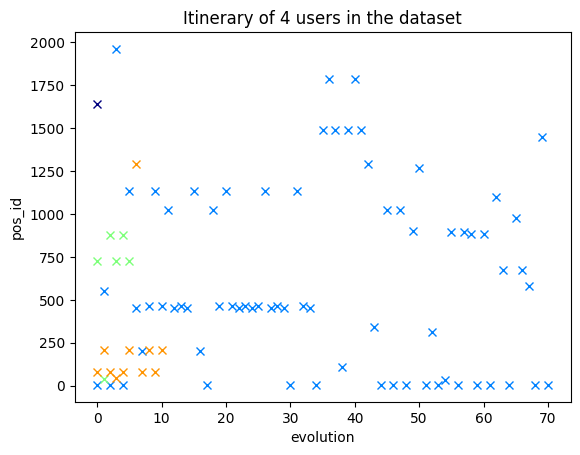

torch.Size([11, 2]) torch.Size([11]) torch.Size([11])
[[], [10, 15, 30, 38, 40, 44, 46, 47, 49, 50, 55, 58, 65, 69, 70, 72, 74, 76, 81, 86, 99, 109, 111, 118, 120, 126, 128, 131, 135, 145, 148, 155, 158, 160, 162, 163, 179, 189, 192, 199, 200, 202, 205, 208, 210, 215, 216, 219, 223, 226, 227, 230, 234, 240, 244, 251, 252, 256, 259, 262, 265, 270, 278, 279, 284, 289, 294, 296, 304, 306, 308, 311, 314, 315, 317, 342, 351, 352, 354, 356, 357, 358, 363, 366, 367, 369, 387, 391, 400, 402, 403, 404, 406, 407, 413, 419, 421, 424, 426, 437, 440, 448, 460, 461, 486, 487, 499, 512, 526, 537, 538, 541, 548, 550, 555, 556, 558, 559, 565, 568, 570, 576, 578, 586, 588, 590, 598, 603, 611, 618, 619, 628, 631, 637, 638, 649, 652, 657, 662, 665, 675, 681, 693, 697, 700, 704, 708, 710, 712, 725, 727, 729, 730, 738, 739, 746, 750, 753, 754, 758, 761, 771, 778, 779, 786, 791, 792, 795, 798, 800, 803, 804, 805, 806, 809, 811, 817, 819, 828, 834, 840, 842, 844, 852, 853, 858, 863, 873, 874, 875, 877, 880, 8

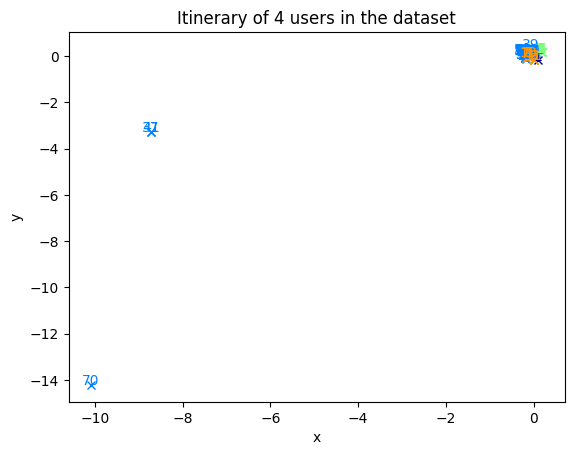

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# plot_nb_users_by_group_of_nuber_of_connections(list_users)

plot_itinerary_users_by_pos_id(list_users, tab_user_id_plot=[1184, 1198, 1206, 1210])
plot_itinerary_users_by_x_y(list_users, tab_user_id_plot=[1184, 1198, 1206, 1210])

# plot_pos_id_with_time_to_end_for_user(list_users, 123)
# plot_pos_id_with_time_to_end_for_user(list_users,124)

# Dataset

## Reproducibility seed

In [ ]:
import hashlib
import string
import random
def get_reproducible_seeds(name="ProjectLong",nb_seeds=100):
    # Calculate SHA-256 hash
    sha256_hash = hashlib.sha256(name.encode()).hexdigest()
    # Define character sets
    digits = string.digits
    # Use the hash to seed the random number generator
    hash_as_int = int(sha256_hash, 16)
    random.seed(hash_as_int)
    # Generate a random list of seed of desired length
    reproducibility_seeds = [random.randint(0,10000) for _ in range(nb_seeds)]

    return reproducibility_seeds

In [ ]:
reproducibility_seed=get_reproducible_seeds()[0]

## Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
class VariableLengthDatasetWithPosID(Dataset):
    def __init__(self, time_series, transform=None):
        self.times_series=time_series
    def __len__(self):
        return len(self.times_series)
    def __getitem__(self, idx):
        user_dict=self.times_series[idx]
        return  user_dict

def create_dataset(list_users,split=[0.8,0.1,0.1]):
  dataset=VariableLengthDatasetWithPosID(list_users)
  generator = torch.Generator().manual_seed(reproducibility_seed)
  dataset_list=torch.utils.data.random_split(dataset,[0.8,0.1,0.1],generator)
  return dataset_list


## Dataloader

In [ ]:
def collate_fn_padd(batch_dict):
    '''
    Padds batch of variable length

    note: it converts things ToTensor manually here since the ToTensor transform
    assume it takes in images rather than arbitrary tensors.
    '''


    dict_batch={key: [d[key] for d in batch_dict] for key in batch_dict[0]}
    dict_batch["lengths"] = torch.tensor([ user["input"].shape[0] for user in batch_dict ])
    if "input" in dict_batch:
      dict_batch["input"] = torch.nn.utils.rnn.pad_sequence(dict_batch["input"],batch_first=True,padding_value=0)
    dict_batch["month"] = torch.nn.utils.rnn.pad_sequence(dict_batch["month"],batch_first=True,padding_value=0)
    dict_batch["day"] = torch.nn.utils.rnn.pad_sequence(dict_batch["day"],batch_first=True,padding_value=0)
    dict_batch["hour"] = torch.nn.utils.rnn.pad_sequence(dict_batch["hour"],batch_first=True,padding_value=24)
    dict_batch["minute"] = torch.nn.utils.rnn.pad_sequence(dict_batch["minute"],batch_first=True,padding_value=60)
    dict_batch["second"] = torch.nn.utils.rnn.pad_sequence(dict_batch["second"],batch_first=True,padding_value=60)

    dict_batch["time_target"] = torch.nn.utils.rnn.pad_sequence(dict_batch["time_target"],batch_first=True,padding_value=-1)
    dict_batch["pos_id"] = torch.nn.utils.rnn.pad_sequence(dict_batch["pos_id"],batch_first=True,padding_value=len(vocab))
    dict_batch["pos_id_target"] = torch.nn.utils.rnn.pad_sequence(dict_batch["pos_id_target"],batch_first=True,padding_value=len(vocab))
    #print(dict_batch["input"])
    return dict_batch

## Instanciate

In [ ]:
dataset_list=create_dataset(list_users)
train_dataset=dataset_list[0]
valid_dataset=dataset_list[1]
test_dataset=dataset_list[2]
train_dataloader=DataLoader(train_dataset,batch_size=64,collate_fn=collate_fn_padd,shuffle=True)
valid_dataloader=DataLoader(valid_dataset,batch_size=256,collate_fn=collate_fn_padd,shuffle=False)
test_dataloader=DataLoader(test_dataset,batch_size=256,collate_fn=collate_fn_padd,shuffle=False)

# Model

## Transformer Encoder followed by LSTM

### transformer

In [ ]:
def get_mask(bath_size,sequence_length,lengths,device):
  mask=torch.zeros(bath_size,sequence_length).to(device)
  for i, length in enumerate(lengths):
    mask[i,length:]=1
  return mask.bool()

#### Positional encoding

In [ ]:
from torch import nn, Tensor
class VanillaPositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 500):
        super().__init__()

        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = (x.transpose(0,1) + self.pe[:x.transpose(0,1).size(0)]).transpose(0,1)
        return self.dropout(x)

In [ ]:
class LearnablePositionalEncoding(nn.Module):

    def __init__(self,d_model: int, dropout: float = 0.1, max_len: int = 500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.positional_embedding=nn.Embedding(num_embeddings=max_len,embedding_dim= d_model)
    @property
    def device(self):
      return next(self.parameters()).device
    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size,seq_len, embedding_dim]``
        """
        x += self.positional_embedding(torch.arange(0,x.shape[1]).to(self.device))
        return self.dropout(x)

In [ ]:
def get_PositionalEncoding(d_model: int, dropout: float = 0.1, max_len: int = 2000, learnable=False):
  if learnable:
    return LearnablePositionalEncoding(d_model, dropout, max_len)
  else:
    return VanillaPositionalEncoding(d_model, dropout, max_len)

#### model

In [ ]:
class Encoder_Decoder_Transformer(nn.Module):
    def __init__(self,d_model,num_layers=3,nhead=10,dropout=0.1,batch_first=True):
      super().__init__()
      self.transformer=torch.nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_layers, num_decoder_layers=num_layers,  dropout=dropout, batch_first=batch_first)
    def forward(self,x,mask,src_key_padding_mask,is_causal):
      return self.transformer(x,
                       x,
                       src_mask=mask,
                       tgt_mask=mask,
                       memory_mask=mask,
                       src_key_padding_mask=src_key_padding_mask,
                       tgt_key_padding_mask=src_key_padding_mask,
                       memory_key_padding_mask=src_key_padding_mask,
                       src_is_causal=is_causal,
                       tgt_is_causal=is_causal,
                       memory_is_causal=is_causal)



def get_Transformer_architecture(d_model,encoder_only=False,num_layers=3,nhead=10,dropout=0.1,batch_first=True):
  if encoder_only:
    encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,batch_first=batch_first)
    return nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
  else:
    return Encoder_Decoder_Transformer(d_model,num_layers,nhead,dropout,batch_first=batch_first)

### feature embedding

In [ ]:
class TimeStampEmbedding(nn.Module):
  def __init__(self,embedding_dim,dropout):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout)
    self.month_embedding = nn.Embedding(num_embeddings=13,embedding_dim=embedding_dim)
    self.day_embedding = nn.Embedding(num_embeddings=32,embedding_dim=embedding_dim)
    self.hour_embedding = nn.Embedding(num_embeddings=25,embedding_dim=embedding_dim)
    self.minute_embedding = nn.Embedding(num_embeddings=61,embedding_dim=embedding_dim)
    self.second_embedding = nn.Embedding(num_embeddings=61,embedding_dim=embedding_dim)

  def forward(self,dict_batch):
    embedding= self.month_embedding(dict_batch['month'])
    embedding=+ self.day_embedding(dict_batch['day'])
    embedding=+ self.hour_embedding(dict_batch['hour'])
    embedding=+ self.minute_embedding(dict_batch['minute'])
    embedding=+ self.second_embedding(dict_batch['second'])
    return self.dropout(embedding)

In [ ]:
class StationIdEmbedding(nn.Module):
  def __init__(self,embedding_dim,nb_of_pos_ids,dropout):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout)
    self.stationIdEmbedding=nn.Embedding(num_embeddings=nb_of_pos_ids,embedding_dim=embedding_dim)
  def forward(self,dict_batch):
    embedding=self.stationIdEmbedding(dict_batch["pos_id"])
    return self.dropout(embedding)


#### graph_deepLearning

In [ ]:
!pip install libpysal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 16.6 MB/s eta 0:00:00


In [ ]:
import os
import torch
if 'IS_GRADESCOPE_ENV' not in os.environ:
  torch_version = str(torch.__version__)
  scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
  sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
  !pip install torch-scatter -f $scatter_src
  !pip install torch-sparse -f $sparse_src
  !pip install torch-geometric
  !pip install ogb

Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 81.0 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=3049d4ae756209f0ed6d2a1856d71ae9d30d88b08233d9124d9ba4a0cbc02455
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
from libpysal.cg import voronoi_frames
from libpysal import weights, examples
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv
import numpy as np
def get_net(vocab):
  x_array=[key[0] for key in vocab]
  y_array=[key[1] for key in vocab]
  coordinates=np.column_stack((x_array,y_array))
  cells, generators = voronoi_frames(coordinates, clip="convex hull")
  delaunay = weights.Rook.from_dataframe(cells)
  delaunay_graph = delaunay.to_networkx()
  positions = dict(zip(delaunay_graph.nodes, coordinates))
  nx.set_node_attributes(delaunay_graph,positions,"coordinates")
  distance=np.linalg.norm(np.concatenate([delaunay_graph.nodes[index[0]]["coordinates"][None,:] for index in delaunay_graph.edges], axis=0)-np.concatenate([delaunay_graph.nodes[index[1]]["coordinates"][None,:] for index in delaunay_graph.edges], axis=0), axis=1)
  nx.set_edge_attributes(delaunay_graph,dict(zip(delaunay_graph.edges,distance)),"distance")
  net=from_networkx(delaunay_graph)
  return net

class GCN(nn.Module):
  def __init__(self, hidden_dim1, hidden_dim2, output_dim,vocab,dropout,device):
    super(GCN, self).__init__()
    net=get_net(vocab)
    self.dropout = nn.Dropout(p=dropout)
    self.edge_index=edge_index = net.edge_index.long().to(device)
    self.distance= net.distance.float().to(device)
    self.coordinates=net.coordinates.float().to(device)
    mean_distance=self.distance.mean()
    std_distance=self.distance.std()
    self.distance=(((self.distance-mean_distance)/std_distance)+1)/2

    mean_coordinates=self.coordinates.mean(dim=0)
    std_coordinates=self.coordinates.std(dim=0)
    self.coordinates=(self.coordinates-mean_coordinates.unsqueeze(0))/std_coordinates.unsqueeze(0)
    self.conv1 = GCNConv(2, hidden_dim1)
    self.conv2 = GCNConv(hidden_dim1, hidden_dim2)
    self.conv3 = GCNConv(hidden_dim2, output_dim)

  @property
  def device(self):
    return next(self.parameters()).device

  def forward(self, dic_batch):
    x = self.conv1(self.coordinates, self.edge_index,self.distance)
    x = F.relu(x)
    x = F.dropout(x, p=0.5, training=self.training)

    x = self.conv2(x, self.edge_index,self.distance)
    x = F.relu(x)
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.conv3(x, self.edge_index,self.distance)
    x=torch.cat((x,torch.zeros(1,x.shape[1]).to(self.device)),dim=0)
    embedding=x[dic_batch["pos_id"]]
    return self.dropout(embedding)


 #### Combine feature embeddng

In [ ]:
class Feature_embedding(nn.Module):

  def __init__(self,d_model,nb_of_pos_ids,use_gcn,vocab,hidden_dim1, hidden_dim2,batch_first,concatenate_features,keep_input_positions,dropout,device):
    super().__init__()
    self.num_features=2+use_gcn
    self.concatenate_features=concatenate_features
    self.embedding_dim=d_model
    self.keep_input_positions=keep_input_positions
    if keep_input_positions:
      self.embedding_dim=self.embedding_dim-2
    if self.concatenate_features:
      self.embedding_dim=int(self.embedding_dim/self.num_features)

    list_feature_embedding=[StationIdEmbedding(self.embedding_dim,nb_of_pos_ids,dropout),TimeStampEmbedding(self.embedding_dim,dropout)]
    if use_gcn:
      list_feature_embedding.append(GCN(hidden_dim1, hidden_dim2, self.embedding_dim, vocab, dropout,device))
    self.list_feature_embedding=nn.ModuleList(list_feature_embedding)

  @property
  def device(self):
    return next(self.parameters()).device

  def forward(self,dic_batch):
    if self.concatenate_features:
      list_embeddings=[]
      for feature_emebdding in self.list_feature_embedding:
        list_embeddings.append(feature_emebdding(dic_batch))
      embedding=torch.cat(list_embeddings,dim=2)
    else:
      embedding=torch.zeros(*dic_batch["pos_id"].shape,self.embedding_dim).to(self.device)
      for feature_emebdding in self.list_feature_embedding:
        embedding+=feature_emebdding(dic_batch)
    if self.keep_input_positions:
      embedding=torch.cat((dic_batch["input"],embedding),dim=2)
    return embedding

### model

In [ ]:
from torch import nn
from torch.nn import Embedding, LSTM



class MLP(nn.Module):
  def __init__(self,d_model):
    super().__init__()
    self.dim_perceptron=2*d_model
    self.linear_perceptron_in=nn.Linear(d_model,self.dim_perceptron)
    self.linear_perceptron_out=nn.Linear(self.dim_perceptron,d_model)

  def forward(self,x):
    return self.linear_perceptron_out(F.relu(self.linear_perceptron_in(x)))


class Transformer_LSTM_Layer(nn.Module):
  def __init__(self,d_model,output_regression_size,output_classfication_size,num_layers,lstm_layer_with_perceptron,lstm_layer_with_layer_norm,dropout,batch_first):
    super().__init__()

    self.lstm=LSTM(input_size=d_model, hidden_size=d_model,batch_first=batch_first,num_layers=1,dropout=dropout)
    self.lstm_layer_with_perceptron=lstm_layer_with_perceptron
    self.lstm_layer_with_layer_norm=lstm_layer_with_layer_norm
    if self.lstm_layer_with_layer_norm:
      self.layer_normalisation=torch.nn.LayerNorm(d_model)
    if self.lstm_layer_with_perceptron:
      self.mlp=MLP(d_model)
    self.dropout=nn.Dropout(p=dropout)

  def forward(self,x,batch_sizes,sorted_indices,unsorted_indices,lengths):
    x=self.lstm(x)[0].data+x.data
    x=torch.torch.nn.utils.rnn.PackedSequence(x, batch_sizes, sorted_indices, unsorted_indices)
    if self.lstm_layer_with_layer_norm:
      x,_=torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True, padding_value=0.0)
      x=self.layer_normalisation(x)
      x=self.dropout(x)
      x=torch.nn.utils.rnn.pack_padded_sequence(x, lengths=lengths,batch_first=True, enforce_sorted=False)
    if self.lstm_layer_with_perceptron:
      x=x.data
      x=self.mlp(x)+x
      x=torch.torch.nn.utils.rnn.PackedSequence(x, batch_sizes, sorted_indices, unsorted_indices)
      if self.layer_normalisation:
        x,_=torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True, padding_value=0.0)
        x=self.layer_normalisation(x)
        x=self.dropout(x)
        x=torch.nn.utils.rnn.pack_padded_sequence(x, lengths=lengths,batch_first=True, enforce_sorted=False)
    return x






class  Transformer_encoder_LSTM_decoder(nn.Module):
  def __init__(self,d_model,nb_of_pos_ids,output_regression_size,output_classfication_size,num_layers_lstm,lstm_layer_with_perceptron,lstm_layer_with_layer_norm,num_layers_transformer,encoder_only,nhead,learnable_pos_encoding,new_station_binary_classification,use_gcn,vocab,hidden_dim1, hidden_dim2,max_len,dropout,batch_first,concatenate_features,keep_input_positions,device):
    super().__init__()
    self.dropout=nn.Dropout(p=dropout)
    self.layer_normalisation=torch.nn.LayerNorm(d_model)
    self.feature_embedding=Feature_embedding(d_model,nb_of_pos_ids,use_gcn,vocab,hidden_dim1, hidden_dim2,batch_first,concatenate_features,keep_input_positions,dropout,device)

    self.num_layers_transformer=num_layers_transformer
    if num_layers_transformer>0:
      self.pos_encoder = get_PositionalEncoding(d_model, dropout, max_len,learnable_pos_encoding)
      self.transformer_model=get_Transformer_architecture(d_model,encoder_only,num_layers_transformer,nhead,dropout,batch_first)

    self.num_layers_lstm=num_layers_lstm
    if num_layers_lstm>0:
      self.transformer_lstm__list = nn.ModuleList([Transformer_LSTM_Layer(d_model,output_regression_size,output_classfication_size,num_layers_lstm,lstm_layer_with_perceptron,lstm_layer_with_layer_norm,dropout,batch_first) for layer in range(num_layers_lstm)])
    self.linear_reg=nn.Linear(d_model,output_regression_size)
    self.classifier=nn.Linear(d_model,output_classfication_size)

    self.new_station_binary_classification=new_station_binary_classification
    if self.new_station_binary_classification:
      self.binary_classifier=nn.Linear(d_model,1)

  @property
  def device(self):
    return next(self.parameters()).device


  def forward(self,dic_batch,reg):
    if self.num_layers_transformer>0:
      x=self.feature_embedding(dic_batch)
      x=self.pos_encoder(x)
      with torch.no_grad():
        mask_x = get_mask(x.shape[0],x.shape[1],dic_batch["lengths"],self.device)
        causal_mask=torch.nn.Transformer.generate_square_subsequent_mask(x.shape[1],device=self.device)
      x=self.transformer_model(x,causal_mask,mask_x,is_causal=True)
    if self.num_layers_lstm>0:
      if self.num_layers_transformer>0:
        x+=self.feature_embedding(dic_batch)
      else:
        x=self.feature_embedding(dic_batch)

    x=torch.nn.utils.rnn.pack_padded_sequence(x, lengths=dic_batch["lengths"],batch_first=True, enforce_sorted=False)
    batch_sizes=x.batch_sizes
    sorted_indices=x.sorted_indices
    unsorted_indices=x.unsorted_indices
    if self.num_layers_lstm>0:
      for transformer_lstm in self.transformer_lstm__list:
        x=transformer_lstm(x,batch_sizes,sorted_indices,unsorted_indices,dic_batch["lengths"])
    x=F.relu(x.data)
    out={}
    out["next_station"]=torch.nn.utils.rnn.PackedSequence(self.classifier(x), batch_sizes, sorted_indices, unsorted_indices)
    if reg:
      out["time_regression"]=torch.nn.utils.rnn.PackedSequence(torch.exp(self.linear_reg(x)), batch_sizes, sorted_indices, unsorted_indices)
    if self.new_station_binary_classification:
      out["new_station"]=  torch.nn.utils.rnn.PackedSequence( self.binary_classifier(x), batch_sizes, sorted_indices, unsorted_indices)
    return out



## Baselines

In [ ]:
from torch import nn
import torch.nn.functional as F
class  Baseline_model(nn.Module):
  def __init__(self,nb_of_pos_ids):
    super().__init__()
    self.nb_of_pos_ids=nb_of_pos_ids
  def forward(self,dic_batch,reg):
    out={}
    out["next_station"]=  torch.nn.utils.rnn.pack_padded_sequence(F.one_hot(dic_batch["pos_id"],self.nb_of_pos_ids).float(), lengths=dic_batch["lengths"],batch_first=True, enforce_sorted=False)
    return out

In [ ]:
model=Baseline_model(len(vocab)+1)
criterion=Total_loss(False)
evaluate(model,valid_dataloader,criterion,device,reg=False)

{'classification': 0.0021053161556483374,
 'total': 0.0021053161556483374,
 'acc': 0.044894637279486165}

# Trainning

In [ ]:
# @title loss
from torch import nn
class Loss_next_station_classification(nn.Module):
  def __init__(self, ) -> None:
    super().__init__()
    self.criterion=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))

  def forward(self, out, target_pos_ids, index_training_element):
    loss_classification=self.criterion(out.data[index_training_element],target_pos_ids.data[index_training_element])
    return loss_classification

class Loss_time_regression(nn.Module):
  def __init__(self, ) -> None:
    super().__init__()
    self.criterion = nn.MSELoss(reduction='none')
  def forward(self,out,dict_batch):
    time_targets=torch.nn.utils.rnn.pack_padded_sequence(dict_batch["time_target"], lengths=dict_batch["lengths"],batch_first=True, enforce_sorted=False)
    mask_time_targets = (time_targets.data != -1)
    loss_regression=self.criterion(out.data,time_targets.data)
    loss_regression = (loss_regression * mask_time_targets.float()).mean()
    return loss_regression

class Loss_new_station_binary_classification(nn.Module):
  def __init__(self, ) -> None:
    super().__init__()
    self.criterion =  nn.BCEWithLogitsLoss()
  def forward(self,out,target):
    loss_classification=self.criterion(out.data.squeeze(),target.float())
    return loss_classification

def get_repetition_labels(target_pos_ids,pos_ids):

  return (target_pos_ids.data==pos_ids.data).type(torch.LongTensor)

def upsampling_strategy(target, epoch, epochs_new_station_only,pourcentage_of_repeat_training_elment):

    index_non_repeat =(target==0).nonzero()
    coeff=pourcentage_of_repeat_training_elment/(1-pourcentage_of_repeat_training_elment)
    index_for_training= index_non_repeat
    if epoch>= epochs_new_station_only:
      index_repeat = target.nonzero().squeeze()
      nb_non_repeat= index_non_repeat.shape[0]
      slice_repeat=index_repeat[torch.randperm(index_repeat.shape[0])[:int(coeff*nb_non_repeat)]].squeeze()
      index_for_training = torch.cat((index_non_repeat.squeeze(),slice_repeat))
    return index_for_training.squeeze()


class Total_loss(nn.Module):
  def __init__(self,new_station_binary_classification) -> None:
    super().__init__()
    self.loss_next_station_classification = Loss_next_station_classification()
    self.loss_time_regression = Loss_time_regression()
    self.new_station_binary_classification=new_station_binary_classification
    if self.new_station_binary_classification:
      self.loss_new_station_binary_classification=Loss_new_station_binary_classification()

  def forward(self, out, dict_batch, upsampling,upsampling_strategy, reg=False):
    loss={}
    target_pos_ids=torch.nn.utils.rnn.pack_padded_sequence(dict_batch["pos_id_target"], lengths=dict_batch["lengths"],batch_first=True, enforce_sorted=False)
    if self.new_station_binary_classification or upsampling:
      pos_ids=torch.nn.utils.rnn.pack_padded_sequence(dict_batch["pos_id"], lengths=dict_batch["lengths"],batch_first=True, enforce_sorted=False)
      target=get_repetition_labels(target_pos_ids,pos_ids)
    else:
      pos_ids=None
      target=None

    if upsampling:
      index_training_element=upsampling_strategy(target)
    else:
      index_training_element=torch.arange(0,target_pos_ids.data.shape[0])

    loss["classification"]=self.loss_next_station_classification(out["next_station"],target_pos_ids,index_training_element)
    loss["total"]=loss["classification"]
    if self.new_station_binary_classification:
      loss["new_station"]=self.loss_new_station_binary_classification(out["new_station"],target)
      loss["total"]+=loss["new_station"]

    if reg:
      loss["time_regression"]=self.loss_time_regression(out["time_regression"],dict_batch)
      loss["total"]+=loss["time_regression"]

    return loss





In [ ]:
# @title evaluation
from torch import autocast
def evaluate(model,dataloader,upsampling,criterion,device,reg=True):
  model.eval()
  with torch.no_grad():
    acc=0
    nb_points=0
    valid_results={}
    for dict_batch in dataloader:
      for key in dict_batch:
        if key!="lengths":
          dict_batch[key]=dict_batch[key].to(device)
      with autocast(device_type=device.type):
        out=model(dict_batch,reg=reg)
        valid_result=criterion(out,dict_batch,upsampling,None,reg=reg)
        valid_results=get_sum_valid_results(valid_results,valid_result)
        target_pos_ids=torch.nn.utils.rnn.pack_padded_sequence(dict_batch["pos_id_target"], lengths=dict_batch["lengths"],batch_first=True, enforce_sorted=False)
        acc+=(out["next_station"].data.argmax(dim=1)==target_pos_ids.data).sum().item()
        nb_points+=out["next_station"].data.shape[0]
    valid_results=get_mean_valid_results(valid_results,nb_points)
    valid_results["acc"]=acc/nb_points

    return valid_results

In [ ]:
# @title training
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch import autocast
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
def train(
          epochs_classifcation_only,
          epochs_complete_problem,
          input_size,
          num_heads,
          d_model,
          nb_of_pos_ids,
          num_layers_lstm,
          lstm_layer_with_perceptron,
          lstm_layer_with_layer_norm,
          num_layers_transformer,
          encoder_only,
          output_regression_size,
          output_classfication_size,
          nb_batchs,
          dropout,
          max_len,
          weight_decay,
          lr,
          learnable_pos_encoding,
          new_station_binary_classification,
          use_gcn,
          vocab,hidden_dim1, hidden_dim2,
          batch_first,
          concatenate_features,
          keep_input_positions,
          upsampling,
          upsampling_strategy,
          epochs_new_station_only,
          pourcentage_of_repeat_training_elment,
          save_best_model,
          path_best_model,
          batch_size,
          device):

  epochs=epochs_complete_problem+ epochs_classifcation_only
  model=Transformer_encoder_LSTM_decoder(d_model=d_model,
                                         nb_of_pos_ids=nb_of_pos_ids,
                                         output_regression_size=output_regression_size,
                                         output_classfication_size=output_classfication_size,
                                         num_layers_lstm=num_layers_lstm,
                                         lstm_layer_with_perceptron=lstm_layer_with_perceptron,
                                         lstm_layer_with_layer_norm=lstm_layer_with_perceptron,
                                         num_layers_transformer=num_layers_transformer,
                                         encoder_only=encoder_only,
                                         nhead=num_heads,
                                         learnable_pos_encoding=learnable_pos_encoding,
                                         new_station_binary_classification=new_station_binary_classification,
                                         use_gcn=use_gcn,
                                         vocab=vocab,
                                         hidden_dim1=hidden_dim1,
                                         hidden_dim2=hidden_dim2,
                                         max_len=max_len,
                                         dropout=dropout,
                                         batch_first = batch_first,
                                         concatenate_features = concatenate_features,
                                         keep_input_positions = keep_input_positions,device=device
                                         ).to(device)
  if save_best_model:
    os.makedirs(path_best_model,exist_ok =True)
  optimizer_encoder = optim.Adam( model.parameters(), lr=lr, weight_decay=weight_decay)
  criterion = Total_loss( new_station_binary_classification = new_station_binary_classification)
  train_losses, valid_results = {},{}
  best_results={}
  for epoch in range(epochs):
    reg=epoch >= epochs_classifcation_only
    epoch_losses={}
    model.train()
    i=0
    for dict_batch in train_dataloader:
      optimizer_encoder.zero_grad()
      i+=1
      if i>=nb_batchs:
        break
      dict_batch=set_dic_to(dict_batch,device)
      with autocast(device_type=device.type):
        out=model(dict_batch, reg)
        loss=criterion(out, dict_batch,upsampling,lambda target: upsampling_strategy(target,epoch,epochs_new_station_only,pourcentage_of_repeat_training_elment) ,reg)
        loss["total"].backward()
        optimizer_encoder.step()
      epoch_losses=update_epoch_losses(epoch_losses,loss)
      dict_batch.clear()
      loss.clear()
      out.clear()
      del out, loss,dict_batch
    epoch_loss=get_epoch_loss(epoch_losses,batch_size)
    train_losses=update_train_losses(train_losses,epoch_loss,epoch)
    valid_result = evaluate(model,valid_dataloader,upsampling,criterion,device)
    best_results = update_best(model,valid_result,best_results,save_best_model,path_best_model)
    valid_results = update_valid_results(valid_results,valid_result)
    print_results(epoch_loss,valid_result,epoch)

  return best_results

In [ ]:
# @title utils

def set_dic_to(dict_batch,device):
  for key in dict_batch:
    if key!="lengths":
      dict_batch[key]=dict_batch[key].to(device)
  return dict_batch

def is_better(valid_result,best_result,key):
  match key:
    case "acc":
      return valid_result>best_result
    case _:
      return valid_result<best_result

def update_best(model,valid_result,best_results,save_best_model,path_best_model):
  if best_results:
    for key in valid_result:
      if is_better(valid_result[key],best_results[key],key):
        best_results[key]=valid_result[key]
        if save_best_model:
          save_model(model,path_best_model,key)
  else:
    for key in valid_result:
      best_results[key]=valid_result[key]
      if save_best_model:
        save_model(model,path_best_model,key)
  return best_results

def save_model(model,path_best_model,key):
  path=os.path.join(path_best_model,key)
  torch.save(model.state_dict(), path+".pth")

def get_sum_valid_results(valid_result,valid_result_batch):
  if valid_result:
    for key in valid_result_batch:
      valid_result[key]+=valid_result_batch[key].item()
  else:
    for key in valid_result_batch:
      valid_result[key]=valid_result_batch[key].item()
  return valid_result

def get_mean_valid_results(sum_valid_result,nb_element):
  for key in sum_valid_result:
    sum_valid_result[key]/=nb_element

  return sum_valid_result

def update_epoch_losses(dict_of_list,dic):
  if dict_of_list:
    for key in dic:
      dict_of_list[key].append(dic[key].item())
  else:
    for key in dic:
      dict_of_list[key]=[dic[key].item()]
  return dict_of_list

def update_valid_results(dict_of_list,dic):
  if dict_of_list:
    for key in dic:
      dict_of_list[key].append(dic[key])
  else:
    for key in dic:
      dict_of_list[key]=[dic[key]]
  return dict_of_list

def get_epoch_loss(epoch_losses,batch_size):

  epoch_loss={}
  for key in epoch_losses:
    epoch_loss[key]=np.array(epoch_losses[key]).mean()/batch_size
  return epoch_loss

def print_results(epoch_loss,valid_result,epoch):

  print("\nepoch: ",epoch)
  print("train :", end="\t")
  for key in epoch_loss:
    print(key,epoch_loss[key], end="\t")
  print("\nvalid :", end="\t")
  for key in valid_result:
    print(key,valid_result[key], end="\t")

def update_train_losses(train_losses,epoch_loss,epoch):

  if train_losses:
    for key in epoch_loss:
      if key in train_losses:
        train_losses[key].append(epoch_loss[key])
      else:
        train_losses[key]=[float('nan')]*(epoch+1)+[epoch_loss[key]]
  else:
    for key in epoch_loss:
      train_losses[key]=[epoch_loss[key]]
  return train_losses

## Instance of training

In [ ]:
# @title Titre par défaut
model=train(
          epochs_classifcation_only=100,
          epochs_complete_problem =100,
          input_size=2,
          num_heads=12,
          d_model=1200,
          nb_of_pos_ids=len(vocab)+1,
          num_layers_lstm=2,
          lstm_layer_with_perceptron=False,
          lstm_layer_with_layer_norm=False,
          num_layers_transformer=6,
          encoder_only=False,
          output_regression_size=2,
          output_classfication_size=len(vocab)+1,
          nb_batchs=100,
          dropout=0.1,
          max_len=100,
          weight_decay=0,
          lr=1e-3,
          learnable_pos_encoding=True,
          new_station_binary_classification=False,
          use_gcn=False,
          vocab=vocab, hidden_dim1=128, hidden_dim2=256,
          batch_first= True,
          concatenate_features = True,
          keep_input_positions = False,
          upsampling=False,
          upsampling_strategy=upsampling_strategy,
          epochs_new_station_only=0,
          pourcentage_of_repeat_training_elment=0.1,
          save_best_model=True,
          path_best_model="test_0.5",
          device=device,
          batch_size=64
          )

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 7.06 MiB is free. Process 61264 has 14.74 GiB memory in use. Of the allocated memory 13.99 GiB is allocated by PyTorch, and 604.22 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
def evaluate_repeat(model,dataloader,device,reg=True):
  model.eval()
  with torch.no_grad():
    acc=0
    nb_points=0
    repeat=0
    not_repeat=0
    correct_not_repeat=0
    correct_repeat=0
    incorrect_not_repeat_as_repeat=0
    incorrect_not_repeat=0
    valid_results={}
    for dict_batch in dataloader:
      for key in dict_batch:
        if key!="lengths":
          dict_batch[key]=dict_batch[key].to(device)
      with autocast(device_type=device.type):
        out=model(dict_batch,reg=reg)
        target_pos_ids=torch.nn.utils.rnn.pack_padded_sequence(dict_batch["pos_id_target"], lengths=dict_batch["lengths"],batch_first=True, enforce_sorted=False)
        acc+=(out["next_station"].data.argmax(dim=1)==target_pos_ids.data).sum().item()
        nb_points+=out["next_station"].data.shape[0]
        pred=out["next_station"].data.argmax(dim=1)
        pos_ids=torch.nn.utils.rnn.pack_padded_sequence(dict_batch["pos_id"], lengths=dict_batch["lengths"],batch_first=True, enforce_sorted=False)
        for i in range(len(target_pos_ids.data)):
          if target_pos_ids.data[i]==pos_ids.data[i]:
            repeat+=1

            if target_pos_ids.data[i]==pred[i]:
              correct_repeat+=1
          else:
            not_repeat+=1
            if target_pos_ids.data[i]==pred[i]:
              correct_not_repeat+=1
            if target_pos_ids.data[i]!=pred[i]:
              incorrect_not_repeat+=1

          if pred[i]==pos_ids.data[i] and target_pos_ids.data[i]!=pos_ids.data[i]:
            incorrect_not_repeat_as_repeat+=1
    print(nb_points,"repeat: ",repeat," not_repeat: ",not_repeat," correct_repeat/repeat: ",correct_repeat/repeat," correct_not_repeat/not_repeat: ",correct_not_repeat/not_repeat,incorrect_not_repeat_as_repeat/incorrect_not_repeat)
    return valid_results

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=768,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=0,
                                         num_layers_transformer=6,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test_0.5/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-18-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.6509191238701378  correct_not_repeat/not_repeat:  0.2762021385930769 0.4746223564954683


{}

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=600,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=12,
                                         num_layers_transformer=0,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test_0.5/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-18-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.572683570872406  correct_not_repeat/not_repeat:  0.24545712973693992 0.38929461542920074


{}

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=600,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=10,
                                         num_layers_transformer=0,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test_0.5/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-18-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.5703307491790515  correct_not_repeat/not_repeat:  0.22293411471430757 0.40792435839711844


{}

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=600,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=2,
                                         num_layers_transformer=0,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test_0.5/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-18-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.44894038389925184  correct_not_repeat/not_repeat:  0.29502962979160746 0.2873538261112317


{}

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=888,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=2,
                                         num_layers_transformer=5,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-18-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=1008,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=6,
                                         num_layers_transformer=6,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test_0.5/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-19-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.7462507193879279  correct_not_repeat/not_repeat:  0.23080623646979073 0.5669490561746645


{}

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=1008,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=2,
                                         num_layers_transformer=0,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test_0.5/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-18-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.4839957344527574  correct_not_repeat/not_repeat:  0.35011261507511315 0.2974764468371467


{}

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=1008,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=6,
                                         num_layers_transformer=6,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test_0.5/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-19-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.6290835844138258  correct_not_repeat/not_repeat:  0.26852681988148086 0.44345460524349045


{}

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=888,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=2,
                                         num_layers_transformer=5,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-19-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.5781001387995531  correct_not_repeat/not_repeat:  0.3046073779274453 0.4137291280148423


{}

In [ ]:
model=Transformer_encoder_LSTM_decoder(d_model=888,
                                         nb_of_pos_ids=len(vocab)+1,
                                         output_regression_size=2,
                                         output_classfication_size=len(vocab)+1,
                                         num_layers_lstm=3,
                                         num_layers_transformer=6,
                                         encoder_only=False,
                                         nhead=12,
                                         learnable_pos_encoding=True,
                                         new_station_binary_classification=False,
                                         use_gcn=True,
                                         vocab=vocab,
                                         hidden_dim1=128,
                                         hidden_dim2=256,
                                         max_len=100,
                                         dropout=0.1,
                                         batch_first = True,
                                         concatenate_features = False,
                                         keep_input_positions = False,device=device
                                         ).to(device)

model.load_state_dict(torch.load("test/acc.pth"))
evaluate_repeat(model,test_dataloader,device)

<ipython-input-19-cfd962976380>:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  delaunay = weights.Rook.from_dataframe(cells)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


RuntimeError: Error(s) in loading state_dict for Transformer_encoder_LSTM_decoder:
	Missing key(s) in state_dict: "transformer_model.transformer.encoder.layers.5.self_attn.in_proj_weight", "transformer_model.transformer.encoder.layers.5.self_attn.in_proj_bias", "transformer_model.transformer.encoder.layers.5.self_attn.out_proj.weight", "transformer_model.transformer.encoder.layers.5.self_attn.out_proj.bias", "transformer_model.transformer.encoder.layers.5.linear1.weight", "transformer_model.transformer.encoder.layers.5.linear1.bias", "transformer_model.transformer.encoder.layers.5.linear2.weight", "transformer_model.transformer.encoder.layers.5.linear2.bias", "transformer_model.transformer.encoder.layers.5.norm1.weight", "transformer_model.transformer.encoder.layers.5.norm1.bias", "transformer_model.transformer.encoder.layers.5.norm2.weight", "transformer_model.transformer.encoder.layers.5.norm2.bias", "transformer_model.transformer.decoder.layers.5.self_attn.in_proj_weight", "transformer_model.transformer.decoder.layers.5.self_attn.in_proj_bias", "transformer_model.transformer.decoder.layers.5.self_attn.out_proj.weight", "transformer_model.transformer.decoder.layers.5.self_attn.out_proj.bias", "transformer_model.transformer.decoder.layers.5.multihead_attn.in_proj_weight", "transformer_model.transformer.decoder.layers.5.multihead_attn.in_proj_bias", "transformer_model.transformer.decoder.layers.5.multihead_attn.out_proj.weight", "transformer_model.transformer.decoder.layers.5.multihead_attn.out_proj.bias", "transformer_model.transformer.decoder.layers.5.linear1.weight", "transformer_model.transformer.decoder.layers.5.linear1.bias", "transformer_model.transformer.decoder.layers.5.linear2.weight", "transformer_model.transformer.decoder.layers.5.linear2.bias", "transformer_model.transformer.decoder.layers.5.norm1.weight", "transformer_model.transformer.decoder.layers.5.norm1.bias", "transformer_model.transformer.decoder.layers.5.norm2.weight", "transformer_model.transformer.decoder.layers.5.norm2.bias", "transformer_model.transformer.decoder.layers.5.norm3.weight", "transformer_model.transformer.decoder.layers.5.norm3.bias", "transformer_lstm__list.2.layer_normalisation.weight", "transformer_lstm__list.2.layer_normalisation.bias", "transformer_lstm__list.2.lstm.weight_ih_l0", "transformer_lstm__list.2.lstm.weight_hh_l0", "transformer_lstm__list.2.lstm.bias_ih_l0", "transformer_lstm__list.2.lstm.bias_hh_l0", "transformer_lstm__list.2.mlp.linear_perceptron_in.weight", "transformer_lstm__list.2.mlp.linear_perceptron_in.bias", "transformer_lstm__list.2.mlp.linear_perceptron_out.weight", "transformer_lstm__list.2.mlp.linear_perceptron_out.bias". 

In [ ]:
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
evaluate(model,test_dataloader,criterion_classification,criterion_regression)

163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.8564101696062832  correct_not_repeat/not_repeat:  0.09422492401215805 0.8021341316208778


(0.643730131126935, 2.2387092113494873, 4.385555267333984)

In [ ]:
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
evaluate(model,test_dataloader,criterion_classification,criterion_regression)

163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.6269508107925116  correct_not_repeat/not_repeat:  0.24020904856661782 0.4275024463247568


(0.5190344566683142, 3.329756021499634, 2.0473709106445312)

In [ ]:
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
evaluate(model,test_dataloader,criterion_classification,criterion_regression)

163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.7019025694844104  correct_not_repeat/not_repeat:  0.2555815529946863 0.5174044590664747


(0.5773612306040138, 2.5278093814849854, 2.7385761737823486)

In [ ]:
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
evaluate(model,test_dataloader,criterion_classification,criterion_regression)

163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.7179745421307424  correct_not_repeat/not_repeat:  0.2436203013273272 0.5562012142237641


(0.5856108172094187, 2.1441447734832764, 1.2037302255630493)

In [ ]:
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
evaluate(model,test_dataloader,criterion_classification,criterion_regression)

163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.8789227800534886  correct_not_repeat/not_repeat:  0.11254947409853272 0.8136211314803864


(0.6650741059388481, 1.82258939743042, 2.1341636180877686)

In [ ]:
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
evaluate(model,test_dataloader,criterion_classification,criterion_regression)

163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.8187565591252243  correct_not_repeat/not_repeat:  0.1462683956178522 0.7372573126376722


(0.6311055788439596, 2.027265787124634, 2.6414260864257812)

In [ ]:
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
evaluate(model,test_dataloader,criterion_classification,criterion_regression)


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.3789143166661024  correct_not_repeat/not_repeat:  0.3284642802475345 0.28316509280364704


(0.3648367472709855, 2.700303077697754, 3.602348566055298)

In [ ]:
criterion_classification=torch.nn.CrossEntropyLoss(ignore_index=len(vocab))
criterion_regression=mse_loss = nn.MSELoss(reduction='none')
evaluate(model,test_dataloader,criterion_classification,criterion_regression)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


163887 repeat:  118156  not_repeat:  45731  correct_repeat/repeat:  0.4562527506009005  correct_not_repeat/not_repeat:  0.30379829874702063 0.3240153275959545


(0.4137118868488654, 2.806699752807617, 3.5753602981567383)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()
torch.cuda.memory_allocated()

7411692032

In [ ]:
if None:
  print(1)

# Decision tree classifier

In [ ]:
# list_users

In [6]:
all_inputs,pos_id_targets=inputs_for_classification(list_users, pos_id=True, user_id=True, date_time=True, time_to_end=True, time_to_end_and_target=False, delete_data_less_nb_min=True, nb_min=5)

In [7]:
inputs, outputs = inputs_outputs_for_classification(all_inputs,pos_id_targets)
# outputs = get_x_y_target_from_outputs(outputs, vocab)
print(inputs[0])
outputs[0]
print(list_users1[0])
print(list_users2[0])

len of the dataset
67085 67085
tensor([0.0000e+00, 5.7183e-02, 8.8420e-02, 4.0500e+02, 9.0000e+00, 1.7000e+01,
        2.3000e+01, 2.9000e+01, 2.4000e+01, 1.0267e+00])
{'pos_id': tensor([604]), 'month': tensor([9]), 'day': tensor([24]), 'hour': tensor([18]), 'minute': tensor([11]), 'second': tensor([1]), 'pos_id_target': tensor([604]), 'input': tensor([[0.1300, 0.1295]]), 'time_target': tensor([[-0.5447,  0.3086]])}
{'pos_id': tensor([276, 198, 405, 276, 405]), 'month': tensor([9, 9, 9, 9, 9]), 'day': tensor([ 8, 12, 12, 13, 14]), 'hour': tensor([12, 20, 20, 10,  3]), 'minute': tensor([36, 38, 40, 57, 39]), 'second': tensor([23, 51, 28, 38, 21]), 'pos_id_target': tensor([198, 405, 276, 405, 405]), 'input': tensor([[0.0589, 0.0930],
        [0.0580, 0.0901],
        [0.0513, 0.0848],
        [0.0589, 0.0930],
        [0.0513, 0.0848]]), 'time_target': tensor([[-0.6675,  0.2957],
        [-0.6564,  0.3187],
        [ 1.7115,  0.2037],
        [-0.6651,  0.2340],
        [-0.6234,  0.3201

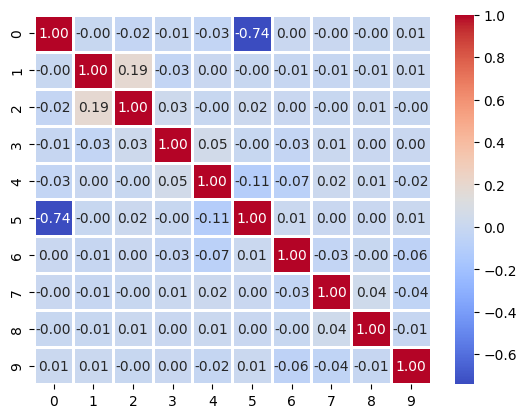

In [8]:
import seaborn as sns
import pandas as pd

def get_correlation(inputs):
    df = pd.DataFrame(inputs)
    corr = df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)
    return corr

corr = get_correlation(inputs)

In [9]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [10]:
#Do cross validation
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.15, random_state=1)

In [11]:
from sklearn.metrics import f1_score

#got best decision tree classifier
# 'criterion': ['gini', 'entropy'],
parameters = { 'criterion': ['gini', 'entropy'], 'max_depth': [ i for i in range(5,50,10)], 'min_samples_split': [ i for i in range(5,40,10)], 'splitter':['best', 'random']}
best_score = -1
# for criterion in parameters['criterion']:
for criterion in parameters['criterion']:
  for max_depth in parameters['max_depth']:
    for min_samples_split in parameters['min_samples_split']:
      for splitter in parameters['splitter']:
        clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, splitter=splitter, random_state=12)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = f1_score(y_test, y_pred, average='weighted')
        print(score)
        if score > best_score:
          best_score = score
          best_parameters = {'criterion': criterion, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'splitter':splitter}

0.014641973770076026
0.005361314728962395
0.01463536515802652
0.004197506335050218
0.01463536515802652
0.004900703612929171
0.01463536515802652
0.004900703612929171
0.2643063347035141
0.23567731138510478
0.27188562991236326
0.2349521699723383
0.2725680517141168
0.24280935424517808
0.27182991746055796
0.20049915670189158
0.29781107947001095
0.31455047740357844
0.32314382719006784
0.34861043037874057
0.3270308995393475
0.3167626556819343
0.327315233359562
0.3010756474258258
0.29634409716911964
0.31511528450605614
0.3233575576763776
0.35061676119617036
0.3274664182826994
0.3156284113179177
0.3272968938332389
0.3136489293413735
0.29442642529487734
0.31511528450605614
0.32356430182990215
0.35061676119617036
0.3274664182826994
0.3156284113179177
0.3272968938332389
0.3136489293413735
0.012318865337938948
0.004283624188623537
0.012318865337938948
0.004283624188623537
0.012318865337938948
0.004283624188623537
0.012318865337938948
0.004283624188623537
0.3115807314738316
0.2993659387646265
0.3268

In [49]:
print("best score: ",best_score)
print(best_parameters)
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
print("cross score: ",cv_scores)

best score:  0.6807267331679286
{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 35, 'splitter': 'best'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


cross score:  [0.67047553 0.67142358 0.67007634 0.65748503 0.66706587]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameters = { 'n_estimators': [ i for i in range(50,150,30)], 'max_depth': [ i for i in range(10,30,10)], 'min_samples_split': [ i for i in range(20,40,10)]}

clf = RandomForestClassifier()
clf = GridSearchCV(clf, parameters, cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.best_score_)
print(clf.best_estimator_)
print(clf.best_index_)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor

# Créer un modèle d'arbre de décision
model = RandomForestClassifier(n_estimators=10, min_samples_leaf = 5, max_features = 0.7, random_state=42)
# model = DecisionTreeClassifier(criterion='entropy')
# model = SVC(random_state=42)
# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
# y_pred = model.predict(X_test)

# Calculer l'exactitude
accuracy = model.score(X_test, y_test)
print("Exactitude :", accuracy)
print(model.get_params())
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print("cross score: ",cv_scores)

In [ ]:
# pip install catboost
from sklearn.ensemble import GradientBoostingClassifier

# Créer un modèle d'arbre de décision
# model = RandomForestClassifier(n_estimators=50, min_samples_leaf = 5, max_features = 0.7, random_state=42)
model = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_depth=10)
# model = SVC(random_state=42)
# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Calculer l'exactitude
accuracy = accuracy_score(y_test, y_pred)
print("Exactitude :", accuracy)
print(model.get_params())
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print("cross score: ",cv_scores)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

inputs = [inp.tolist() for inp in inputs]
outputs = [inp.tolist() for inp in outputs]
#Do cross validation
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.25, random_state=1)
# Créer un modèle d'arbre de décision
# model = KNeighborsClassifier(n_neighbors=5, metric='l2')
# model = DecisionTreeClassifier(criterion='entropy')
model = CatBoostClassifier(iterations=50, learning_rate=0.1, loss_function='MultiClass')
# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Calculer l'exactitude
accuracy = accuracy_score(y_test, y_pred)
print("Exactitude :", accuracy)
print(model.get_params())
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print("cross score: ",cv_scores)

0:	learn: 7.2019131	total: 3m 33s	remaining: 2h 54m 33s
1:	learn: 6.8811740	total: 7m 2s	remaining: 2h 48m 54s


{(31.32719, 121.53013): 1, (31.11794, 121.457471): 2, (31.245393, 121.705496): 3, (31.094914, 121.43682): 4, (31.155344, 121.2025): 5, (31.044667, 121.46191): 6, (31.112344, 121.480257): 7, (31.128227, 121.45441): 8, (31.118723, 121.248449): 9, (31.125695, 121.46401): 10, (30.824719, 121.471519): 11, (31.146551, 121.235394): 12, (30.832601, 121.445485): 13, (31.298668, 121.541944): 14, (30.950067, 121.449083): 15, (31.130891, 121.472384): 16, (31.01217, 121.265575): 17, (31.130862, 121.091425): 18, (31.25821, 121.479271): 19, (31.225831, 121.412695): 20, (31.264503, 121.715846): 21, (31.121127, 121.243829): 22, (31.019691, 121.249497): 23, (31.205813, 121.413544): 24, (31.214115, 121.406884): 25, (31.287632, 121.458734): 26, (31.294609, 121.526886): 27, (31.121152, 121.141999): 28, (31.327299, 121.452936): 29, (31.109998, 121.164842): 30, (31.260742, 121.399188): 31, (31.198372, 121.355749): 32, (31.177169, 121.445517): 33, (31.138371, 121.416975): 34, (31.137509, 121.40768): 35, (31.2

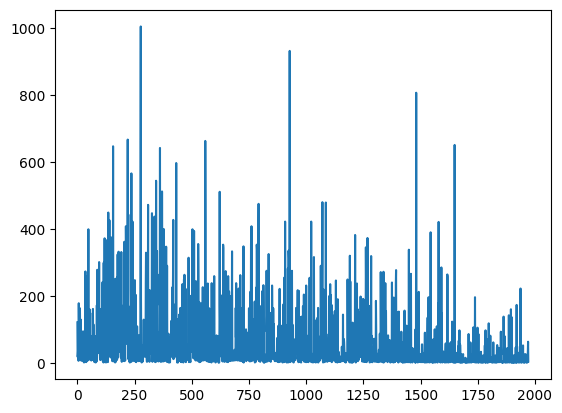

In [16]:
#Create a dictionary with the number of data for each class
class_count={}
print(vocab)
pos_ids = [i[3] for i in inputs]
for pos_id in pos_ids:
    if pos_id.item() in class_count:
      class_count[pos_id.item()]+=1
    else:
      class_count[pos_id.item()]=1
print(class_count)
print(len(class_count))
print(max(class_count.keys()))


import matplotlib.pyplot as plt

#See the tendency of the number of connections for each class
print("min number of connections for each class"
      ,min(class_count.values())
      ,min(class_count,key=class_count.get))
print("max number of connections for each class"
      ,max(class_count.values())
      ,max(class_count,key=class_count.get))

plt.plot(list(class_count.values()))
plt.show()

# XGBoost Approach

In [ ]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [ ]:

# inputs = [inp.tolist() for inp in inputs]
# outputs = [out.tolist() for out in outputs]
print(inputs[0])
print(outputs[0])
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.3, random_state=1)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

tensor([ 0.0000e+00, -2.6449e-02,  8.2146e-02,  5.2800e+02,  6.0000e+00,
         1.0000e+00,  2.0000e+00,  3.7000e+01,  7.0000e+00, -2.7597e-01,
         2.6717e-01])
tensor(874)


In [ ]:
parameters = {'max_depth': 3, 'colsample_bytree': 0.8, 'eta': 0.01, 'subsample': 1.0, 'alpha': 0, 'lambda': 1, 'min_child_weight': 5}

# model = xgb.XGBRegressor(**parameters)
model = xgb.XGBClassifier(max_depth=3, eta=0.01, subsample=1.0, alpha=0, min_child_weight=5,  colsample_bytree=0.8, gpu_id=0)
print(model)

model.fit(X_train, y_train_encoded)

score = model.score(X_test, y_test_encoded)
print("score: ",score)
# cv_scores = cross_val_score(model, X_train, y_train_encoded, cv=5)
# print("cross score: ",cv_scores)

#Predict the next position
y_pred = model.predict(X_test)

#Evaluate the model
print("Accuracy:", metrics.accuracy_score(y_test_encoded, y_pred))

XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None, ...)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [10:47:53] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [10:47:53] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


score:  0.006807481867922127
Accuracy: 0.006807481867922127


In [ ]:
#Encode the target


#go to GPU
# X_train = X_train.to('cuda')
# X_test = X_test.to('cuda')
# y_train_encoded = torch.tensor(y_train_encoded).to('cuda')
# y_test_encoded = torch.tensor(y_test_encoded).to('cuda')
#Search for the best parameters
# 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
# 'learning_rate': [0.05, 0.1, 0.15, 0.2],
# 'n_estimators': [100, 200, 300, 400, 500],
# 'gamma': [0, 0.1, 0.2, 0.3, 0.4],
# 'min_child_weight': [1, 2, 3, 4, 5]
# parameters = {'max_depth': [30, 40, 50, 60, 70, 80, 90, 100], 'learning_rate': [0.05, 0.1, 0.15, 0.2], 'n_estimators': [50, 70, 100, 130, 170], 'gamma': [0, 0.1, 0.2, 0.3, 0.4], 'min_child_weight': [5, 10, 20, 30, 40]}
parameters = {'max_depth': [10, 20], 'learning_rate': [0.1, 0.2], 'n_estimators': [50, 70, 100], 'gamma': [0.2, 0.3, 0.4], 'min_child_weight': [10, 5]}
# parameters = {'max_depth': [10, 20], 'learning_rate': [0.1, 0.2], 'n_estimators': [30, 50, 10], 'gamma': [0.2], 'min_child_weight': [10, 5]}

best_score = -1

for max_depth in parameters['max_depth']:
    for learning_rate in parameters['learning_rate']:
        for n_estimators in parameters['n_estimators']:
            for gamma in parameters['gamma']:
                for min_child_weight in parameters['min_child_weight']:
                    model = xgb.XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, gamma=gamma, min_child_weight=min_child_weight, eta = 0.005,  gpu_id=0) #, gpu_id=0
                    model.fit(X_train, y_train_encoded)
                    score = model.score(X_test, y_test_encoded)
                    print(score)
                    if score > best_score:
                        best_score = score
                        best_parameters = {'max_depth': max_depth, 'learning_rate': learning_rate, 'n_estimators': n_estimators, 'gamma': gamma, 'min_child_weight': min_child_weight}

print("best score: ",best_score)
print(best_parameters)
# cv_scores = cross_val_score(model, X_train, y_train_encoded, cv=5)
print("cross score: ",cv_scores)

#Predict the next position
y_pred = model.predict(X_test)

#Evaluate the model
print("Accuracy:", metrics.accuracy_score(y_test_encoded, y_pred))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:07:09] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:07:09] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


0.008525257666369766


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:15:00] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


0.010115790813080545


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:23:17] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


0.008270772362896042


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:30:51] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


0.009861305509606821


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:39:51] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


0.008461636340501335


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:47:34] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


0.009861305509606821


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:55:51] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


0.009161470925054078


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:06:18] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


0.010115790813080545


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:18:16] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


0.009352334902659371


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:28:58] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


0.0104338974424227


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:41:21] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


KeyboardInterrupt: 

# GRU

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Séparation des données par utilisateur et organisation en séquences temporelles
user_sequences = {}
for entry in inputs_with_pos_id_user_id_target:
    user_id, position, time = entry[0], entry[1::2], entry[2::2]
    if user_id not in user_sequences:
        user_sequences[user_id] = []
    user_sequences[user_id].append((position, time))

# Normalisation des données
scaler = MinMaxScaler()
for user_id, sequences in user_sequences.items():
    positions = [pos for seq in sequences for pos in seq[0]]
    times = [time for seq in sequences for time in seq[1]]
    positions_scaled = scaler.fit_transform(np.array(positions).reshape(-1, 1))
    times_scaled = scaler.fit_transform(np.array(times).reshape(-1, 1))
    user_sequences[user_id] = [(positions_scaled[i], times_scaled[i]) for i in range(len(positions_scaled))]

# Padding des séquences
max_sequence_length = max(len(seq) for seq in user_sequences.values())
for user_id, sequences in user_sequences.items():
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', dtype='float32')

# Encodage des séquences (si nécessaire)

# Fractionnement des données
train_data, val_data, test_data = {}, {}, {}
for user_id, sequences in user_sequences.items():
    train_size = int(0.7 * len(sequences))
    val_size = int(0.15 * len(sequences))
    train_data[user_id] = sequences[:train_size]
    val_data[user_id] = sequences[train_size:train_size+val_size]
    test_data[user_id] = sequences[train_size+val_size:]
